In [29]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import torch


# This allows you to edit the imported modules (e.g code in other files) without having to restart the kernel.
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Deep neural networks have shown staggering performances in various learning tasks, including computer vision, natural language processing, and sound processing. They have made the model design more flexible by enabling end-to-end training.

In this exercise, we get to have a first hands-on experience with neural network training. Many frameworks (e.g., PyTorch, Tensorflow, Caffe) allow easy usage of deep neural networks without precise knowledge of the inner workings of backpropagation and gradient descent algorithms. While these are very useful tools, it is important to get a good understanding of how to implement basic network training from scratch before using these libraries to speed up the process. For this purpose, we will implement a simple two-layer neural network and its training algorithm based on back-propagation using only basic matrix operations in questions 1 to 3. In question 4, we will use a popular deep learning library, PyTorch, to do the same and understand the advantages offered by using such tools.

As a benchmark to test our models, we consider an image classification task using the widely used CIFAR-10 dataset. This dataset consists of 50000 training images of 32x32 resolution with 10 object classes, namely airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The task is to code and train a parametrized model for classifying those images. This involves

- Implementing the feedforward model (Question 1).
- Implementing the backpropagation algorithm (gradient computation) (Question 2).
- Training the model using stochastic gradient descent and improving the model training with better hyper-parameters (Question 3).
- Using the PyTorch Library to implement the above and experiment with deeper networks (Question 4).

A note on notation: Throughout the exercise, notation $v_i$ is used to denote the $i$-th element of vector $v$.

### Question 1: Implementing the feedforward model (10 points)

In this question, we will implement a two-layered neural network architecture and the loss function to train it.

![Failed to load image from ./data/exercise-2/fig1.png You can view it manually](./data/exercise-2/fig1.png)

**Model architecture.** Our architecture is shown in Fig.1. It has an input layer and two model layers – a hidden and an output layer. We start with randomly generated toy inputs of four dimensions and the number of classes K = 3 to build our model in Q1 and Q2, and in Q3 use images from the CIFAR-10 dataset to test our model on a real-world task. Hence input layer is 4-dimensional for now.

In the hidden layer, there are 10 units. The input layer and the hidden
layer are connected via linear weighting matrix $W^{(1)}\in\mathbb{R}^{10\times
4}$ and the bias term $b^{(1)}\in\mathbb{R}^{10}$. The parameters $W^{(1)}$
and $b^{(1)}$ are to be learnt later on. A linear operation is performed,
$W^{(1)}x+b^{(1)}$, resulting in a 10 dimensional vector $z^{(2)}$. It is then
followed by a relu non-linear activation $\phi$, applied element-wise on each
unit, resulting in the activations $a^{(2)} = \phi(z^{(2)})$. Relu function has
the following form:

\begin{equation}
\phi(u) =  \begin{cases}
      u, & \text{if}\ u\geq0 \\
      0, & \text{if}\ u <0
    \end{cases}
\end{equation}

A similar linear operation is performed on $a^{(2)}$, resulting in $z^{(3)}=W^{(2)}a^{(2)}+b^{(2)}$, where $W^{(2)}\in\mathbb{R}^{3\times 10}$ and $b^{(2)}\in\mathbb{R}^{3}$; it is followed by the softmax activation to result in $a^{(3)}=\psi(z^{(3)})$. The softmax function is defined by:
\begin{equation}
\psi(u)_i =  \frac{\exp^{u_i}}{\sum_j{\exp^{u_j}}} 
\end{equation}

The final functional form of our model is thus defined by

\begin{align*}
a^{(1)} &= x \\ \
z^{(2)} &= W^{(1)}a^{(1)}+b^{(1)} \\
a^{(2)} &= \phi(z^{(2)}) \\
z^{(3)} &= W^{(2)}a^{(2)}+b^{(2)} \\
f_\theta(x) := a^{(3)} &= \psi(z^{(3)}),
\end{align*}

which takes a flattened 4 dimensional vector as input and outputs a $3$ dimensional vector, each entry in the output $f_k(x)$ representing the probability of image $x$ corresponding to the class $k$. We summarily indicate all the network parameters by $\theta=(W^{(1)},b^{(1)},W^{(2)},b^{(2)})$.

**Implementation.** We are now ready to implement the feedforward neural network.

a) Implement the feedforward model. Verify that the scores you generate for the toy inputs match the correct scores. (5 points)

In [30]:
import models.twolayernet.model as module_twolayernet
from utils.utils import seed_everything, init_toy_data, rel_error
from utils.gradient_check import eval_numerical_gradient

In [31]:
seed_everything(1)

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

# You would need to implement the forward() pass of the TwoLayerNetv1 module.
net = module_twolayernet.TwoLayerNetv1(input_size=input_size, hidden_size=hidden_size, output_size=num_classes, std=1e-1)
X, y = init_toy_data(num_inputs, input_size)

scores = net.forward(X)
print('Your scores:')
print(scores)
print()
print('Correct scores:')
correct_scores = np.asarray([
 [0.36446210, 0.22911264, 0.40642526],
 [0.47590629, 0.17217039, 0.35192332],
 [0.43035767, 0.26164229, 0.30800004],
 [0.41583127, 0.29832280, 0.28584593],
 [0.36328815, 0.32279939, 0.31391246]])
print(correct_scores)

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

assert math.isclose(np.sum(np.abs(scores - correct_scores)), 0,  abs_tol=1e-6)

Your scores:
[[0.3644621  0.22911264 0.40642526]
 [0.47590629 0.17217039 0.35192332]
 [0.43035767 0.26164229 0.30800004]
 [0.41583127 0.2983228  0.28584593]
 [0.36328815 0.32279939 0.31391246]]

Correct scores:
[[0.3644621  0.22911264 0.40642526]
 [0.47590629 0.17217039 0.35192332]
 [0.43035767 0.26164229 0.30800004]
 [0.41583127 0.2983228  0.28584593]
 [0.36328815 0.32279939 0.31391246]]
Difference between your scores and correct scores:
2.917341163088949e-08


b) We later guide the neural network parameters
$\theta=(W^{(1)},b^{(1)},W^{(2)},b^{(2)})$ to fit the given data and label
pairs. We do so by minimising the loss function. A popular choice of the loss
function for training neural networks for multi-class classification is the
cross-entropy loss. For a single input sample $x_i$, with label $y_i$, the loss
function is defined as:

\begin{align}
J(\theta, x_i, y_i) &= -\log{P(Y=y_i,X=x_i)} \\
                    &= -\log{f_\theta(x_i)_{y_i}} \\
                    &= -\log{\psi(z^{(3)})_{y_i}} \\
J(\theta, x_i, y_i) &= -\log\left[ \frac{\exp^{z^{(3)}_{y_i}}}{\sum^K_j{\exp^{z^{(3)}_j}}}\right]
\end{align}

Averaging over the whole training set, we get 

\begin{align}
J(\theta,\{x_i,y_i\}_{i=1}^{N}) = \frac{1}{N} \sum_{i=1}^N 
-log\left[ \frac{\exp^{z^{(3)}_{y_i}}}{\sum_j{\exp^{z^{(3)}_j}}}\right],
\end{align}

where $K$ is the number of classes. Note that if the model has perfectly fitted
to the data (i.e. $f_\theta^k(x_i)=1$ whenever $x_i$ belongs to class $k$ and 0
otherwise), then $J$ attains the minimum of $0$. 


Apart from trying to correctly predict the label, we have to prevent
overfitting the model to the current training data.  This is done by encoding
our prior belief that the correct model should be simple (Occam's razor); we
add an $L_2$ regularisation term over the model parameters $\theta$.
Specifically, the loss function is defined by:

\begin{align}
\tilde{J}(\theta) = \frac{1}{N} \sum_{i=1}^N
-log\left[ \frac{\exp^{z^{(3)}_{y_i}}}{\sum_j{\exp^{z^{(3)}_j}}}\right]
+\lambda \left(||W^{(1)}||_2^2 + ||W^{(2)}||_2^2 \right),
\end{align}

where $||\cdot||_2^2$ is the squared $L_2$ norm. For example,

\begin{align}
||W^{(1)}||_2^2 = 
\sum_{p=1}^{10} \sum_{q=1}^{4} W_{pq}^{(1)2}
\end{align}

By changing the value of $\lambda$ it is possible to give weights to your prior belief on the degree of simplicity (regularity) of the true model. 

Implement the final loss function and let it return the loss value. Verify the code by
running and matching the output cost $1.30378789133$. (5 points)

In [32]:
net_v2 = module_twolayernet.TwoLayerNetv2(input_size=input_size, hidden_size=hidden_size, output_size=num_classes, std=1e-1) 
loss = net_v2.compute_loss(X, y, reg=0.05)
correct_loss = 1.30378789133 # check this number with your implementation

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

assert math.isclose(np.sum(np.abs(loss - correct_loss)), 0,  abs_tol=1e-6), 'The error with respect to the correct value is too high'

Difference between your loss and correct loss:
1.794120407794253e-13


### Question 2: Backpropagation (15 points)

We train the model by solving
\begin{align}
\underset{\theta}{\min} \,\,  \tilde{J}(\theta)
\end{align}
via stochastic gradient descent. Therefore, We need an efficient computation of the gradients $\nabla_\theta \tilde{J}(\theta)$. We use backpropagation of top layer error signals to the parameters $\theta$ at different layers.

In this question, you will be required to implement the backpropagation algorithm yourself from pseudocode. We will give a high-level description of what is happening in each line.

For those who are interested in the robust derivation of the algorithm, we include the optional exercise on the derivation of the backpropagation algorithm. A piece of prior knowledge of standard vector calculus, including the chain rule, would be helpful.

**Backpropagation.** The backpropagation algorithm is simply a sequential application of the chain rule. It is applicable to any (sub-) differentiable model that is a composition of simple building blocks. In this exercise, we focus on the architecture with stacked layers of linear transformation + relu non-linear activation.

The intuition behind the backpropagation algorithm is as follows. Given a training example $(x, y)$, we first run the feedforward to compute all the activations throughout the network, including the output value of the model $f_\theta(x)$ and the loss $J$. Then, for each parameter in the model, we want to compute the effect that parameter has on the loss. This is done by computing the derivatives of the loss w.r.t for each model parameter.

The backpropagation algorithm is performed from the top of the network (loss layer) to the bottom. It sequentially computes the gradient of the loss function with respect to each layer's activations and parameters.

Let’s start by deriving the gradients of the un-regularized loss function w.r.t final layer activations $z^{(3)}$. We will then use this in the chain rule to compute analytical expressions for gradients of all the model parameters.

(a) Verify that the loss function (in Q1) has the gradient w.r.t $z^{(3)}$ as below.
\begin{equation}
\frac{\partial J}{\partial z^{(3)}}\left(\{x_i,y_i\}_{i=1}^{N}\right) = \frac{1}{N}\left(\psi(z^{(3)}) - \Delta\right), 
\end{equation}
where $\Delta$ is a matrix of $N\times K$ dimensions with 
\begin{align}
        \Delta_{ij} = 1, & \text{if}\ y_i =j \\
                0, & \text{otherwise}
\end{align}
and $z^{(3)}$ here refers to all the activations of the training set.
\begin{align}
        z^{(3)} \in \mathbb R^{N \times K}
\end{align}
(please write your answer in the block below, or attach an image in the same cell, 2 points)


![Failed to load image from ./data/q2_derivations/part_a.png. You can view it manually](./data/q2_derivations/part_a.png)

b) To compute the effect of the weight matrix $W^{(2)}$ on the loss (in Q1) incurred by the network, we compute the
partial derivatives of the loss function with respect to $W^{2}$.  This is done
by applying the chain rule. Verify that the partial derivative of the loss w.r.t $W^{(2)}$ is  

\begin{align}
\frac{\partial J}{\partial W^{(2)}}\left(\{x_i,y_i\}_{i=1}^{N}\right) &= \frac{\partial J}{\partial z^{(3)}} \cdot \frac{\partial z^{(3)}}{\partial W^{(2)}} \\
&= \frac{1}{N} (\psi(z^{(3)}) - \Delta) a^{(2)'}
\end{align}

Similarly, verify that the regularized loss has the derivatives

\begin{align}
\frac{\partial \tilde{J}}{\partial W^{(2)}} = \frac{1}{N} (\psi(z^{(3)}) - \Delta) a^{(2)'} + 2\lambda W^{(2)}
\end{align}

(please write your answer in the block below, or attach an image in the same cell, 2 points)

![Failed to load image from ./data/q2_derivations/part_b.png. You can view it manually](./data/q2_derivations/part_b.png)

c) We can repeatedly apply chain rule as discussed above to obtain the derivatives of the loss with respect to all the parameters of the model $\theta=(W^{(1)},b^{(1)},W^{(2)},b^{(2)})$.
Derive the expressions for the derivatives of the regularized loss (in Q1) w.r.t $W^{(1)}$, $b^{(1)}$, $b^{(2)}$ now.
(please write your answer in the block below, or attach an image in the same cell, 6 points)

![Failed to load image from ./data/q2_derivations/part_c_1.png. You can view it manually](./data/q2_derivations/part_c_1.png)

![Failed to load image from ./data/q2_derivations/part_c_2.png. You can view it manually](./data/q2_derivations/part_c_2.png)

d) Using the expressions you obtained for the derivatives of the loss w.r.t model parameters, implement the back-propagation algorithm. Run the code and verify that the gradients you obtained are correct using numerical gradients (already
implemented in the code). The maximum relative error between the gradients you compute and the numerical gradients should be less than 1e-8 for all parameters.
(5 points)

In [27]:
import models.twolayernet.model as module_twolayernet

In [48]:
net_v3 = module_twolayernet.TwoLayerNetv3(input_size=input_size, hidden_size=hidden_size, output_size=num_classes, std=1e-1)
loss, grads = net_v3.back_propagation(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net_v3.back_propagation(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net_v3.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 3.440708e-09
b2 max relative error: 1.000000e+00
W1 max relative error: 3.669858e-09
b1 max relative error: 1.000000e+00


### Question 3: Stochastic gradient descent training (10 points)

We have implemented the backpropagation algorithm for computing the parameter gradients and have verified that it indeed gives the correct gradient. We are now ready to train the network. We solve Eq.15 with the stochastic gradient descent.

Typically neural networks are large and are trained with millions of data
points. It is thus often infeasible to compute the gradient $\nabla_\theta
\tilde{J}(\theta)$ that requires the accumulation of the gradient over the
entire training set. Stochastic gradient descent addresses this problem by
simply accumulating the gradient over a small random subset of the training
samples (minibatch) at each iteration. Specifically, the algorithm is as
follows,

![Failed to load the image from ./data/exercise-2/alg1.png You can view it manually](./data/exercise-2/alg1.png)

where the gradient $\nabla_\theta \tilde{J}(\theta,\{(X^\prime_j,y^\prime_j)\}_{j=1}^B)$ is computed only on the current randomly sampled batch.

Intuitively, $v = -\nabla_\theta \tilde{J}(\theta^{(t-1)})$ gives the direction
to which the loss $\tilde{J}$ decreases the most (locally), and therefore we
follow that direction by updating the parameters towards that direction
$\theta^{(t)} = \theta^{(t-1)} + v$. 

a) Implement the stochastic gradient descent algorithm and run the training on the toy data. Your model
should be able to  obtain loss <= 0.02 on the training set and the training
curve should look similar to the one shown in figure 2.

![Failed to load the image from ./data/exercise-2/fig2.png Please view it yourself](./data/exercise-2/fig2.png)

Final training loss:  0.016821892079620822


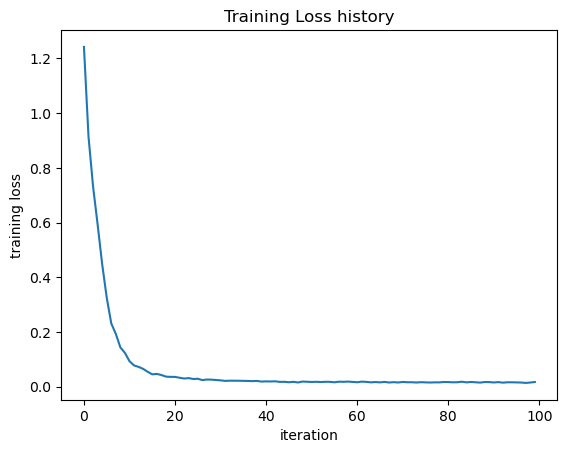

In [49]:
net_v4 = module_twolayernet.TwoLayerNetv4(input_size=input_size, hidden_size=hidden_size, output_size=num_classes, std=1e-1)
stats = net_v4.train(X, y, X, y,
                    learning_rate=1e-1, reg=5e-6,
                    num_iters=100, verbose=True)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

b) We are now ready to train our model on a real image dataset. For this, we will use
the CIFAR-10 dataset.  Since the images are of size $32\times 32$ pixels with 3
color channels, this gives us 3072 input layer units, represented by a vector
$x\in\mathbb{R}^{3072}$. The code to load the data and train the model is provided with
some default hyperparameters. With default
hyperparameters, if previous questions have been done correctly, you should get
a validation set accuracy of about 29\%. This is very poor.
Your task is to debug the model training and come up with better hyperparameters
to improve the performance on the validation set.
Visualize the training and validation performance curves to help with this analysis.
There are several pointers provided in the comments to 
help you understand why the network might be underperforming.
Once you have tuned your hyperparameters, and get validation accuracy greater
than 48\% run your best model on the test set once and report the performance.

**Download CIFAR-10 using this link: <http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz>**
<br/>
**Decompress the downloaded dataset, and put the `cifar-10-batches-py` folder in the folder `data/exercise-2`**

You can also try the next two commented lines (simply uncomment them and run the cell). The commands are tested on Linux

In [53]:
# !wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# !tar -xzf cifar-10-python.tar.gz -C ./data/exercise-2

In [ ]:
from utils.utils import show_net_weights
from utils.data_utils import get_CIFAR10_data
from utils.vis_utils import visualize_grid

In [ ]:
# # Load the data
# Now that you have implemented a two-layer network that passes
# gradient checks and works on toy data, it's time to load up our favorite
# CIFAR-10 data so we can use it to train a classifier on a real dataset.
# Invoke the get_CIFAR10_data function to get our data.

# Load the raw CIFAR-10 data
X_train, y_train, X_val, y_val, X_test, y_test = \
    get_CIFAR10_data(data_dir='./data/exercise-2/cifar-10-batches-py')

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Visualize some images to get a feel for the data
plt.imshow(visualize_grid(X_train[:100, :].reshape(100, 32,32, 3), padding=3).astype('uint8'))
plt.gca().axis('off')
plt.show()

######################## Train a network ########################
# To train our network we will use SGD. In addition, we will
# adjust the learning rate with an exponential learning rate schedule as
# optimization proceeds; after each epoch, we will reduce the learning rate by
# multiplying it by a decay rate.

input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = module_twolayernet.TwoLayerNetv4(input_size=input_size, hidden_size=hidden_size, output_size=num_classes)
# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Evaluate the model on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

######################## Debug the training ##################################
# With the default parameters we provided above, you should get a validation
# accuracy of about 0.29 on the validation set. This isn't very good.
#
# One strategy for getting insight into what's wrong is to plot the loss
# function and the accuracies on the training and validation sets during
# optimization.
# Plot the loss function and train / validation accuracies

fig, axes = plt.subplots(2, 1, figsize=(2*5, 5*1), dpi=100)
axes[0].plot(stats['loss_history'])
axes[0].set_title('Loss history')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')

axes[1].plot(stats['train_acc_history'], label='train')
axes[1].plot(stats['val_acc_history'], label='val')
axes[1].set_title('Classification accuracy history')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Classification accuracy')
axes[1].legend()
plt.show()



# Another strategy is to visualize the weights that were learned in the first
# layer of the network. In most neural networks trained on visual data, the
# first layer weights typically show some visible structure when visualized.
show_net_weights(net)
##############################################################################

Tune the hyper-parameters over the validation set

In [ ]:
# **What's wrong?**. Looking at the visualizations above, we see that the loss
# is decreasing more or less linearly, which seems to suggest that the learning
# rate may be too low. Moreover, there is no gap between the training and
# validation accuracy, suggesting that the model we used has low capacity, and
# that we should increase its size. On the other hand, with a very large model
# we would expect to see more overfitting, which would manifest itself as a
# very large gap between the training and validation accuracy.
#
# **Tuning**. Tuning the hyperparameters and developing intuition for how they
# affect the final performance is a large part of using Neural Networks, so we
# want you to get a lot of practice. Below, you should experiment with
# different values of the various hyperparameters, including hidden layer size,
# learning rate, numer of training epochs, and regularization strength. You
# might also consider tuning the learning rate decay, but you should be able to
# get good performance using the default value.
#
# **Approximate results**. You should aim to achieve a classification
# accuracy of greater than 48% on the validation set. Our best network gets
# over 52% on the validation set.
#
# **Experiment**: You goal in this exercise is to get as good of a result on
# CIFAR-10 as you can (52% could serve as a reference), with a fully-connected
# Neural Network. Feel free implement your own techniques (e.g. PCA to reduce
# dimensionality, or adding dropout, or adding features to the solver, etc.).

# **Explain your hyperparameter tuning process in the report.**

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters- by hand can be fun, but you might find it useful to #
# write code to sweep through possible combinations of hyperparameters          #
# For example you can write                                                     #
#   for learning_rate in my_learning_rates:                                     #
#     ...                                                                       #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# stats = best_net.train(X_train, y_train, X_val, y_val,
#             num_iters=, batch_size=,
#             learning_rate=, learning_rate_decay=,
#             reg=, verbose=True)

best_net = net # store your best model into this

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Predict on the validation set
val_acc = (best_net.predict(X_val) == y_val).mean()
print(f'Validation accuracy: {val_acc*100 : 0.2f}')
show_net_weights(best_net)


Run on test set

In [ ]:
# When you are done experimenting, you should evaluate your final trained
# network on the test set; you should get more than 48% accuracy on the test set.

test_acc = (best_net.predict(X_test) == y_test).mean()
print(f'Test accuracy: {test_acc*100:0.2f}')

### Question 4: Implement multi-layer perceptron using PyTorch library (10 points)

So far, we have implemented a two-layer network by explicitly writing down the expressions for the forward and backward computations and training algorithms using simple matrix multiplication primitives from the NumPy library.

However there are many libraries available designed make experimenting with neural networks faster by abstracting away the details into re-usable modules. One such popular open-source library is PyTorch (https://pytorch.org/). In this final question we will use the PyTorch library to implement the same two-layer network we did before and train it on the Cifar-10 dataset. However, extending a two-layer network to a three or four layered one is a matter of changing two-three lines of code using PyTorch. We will take advantage of this to experiment with deeper networks to improve the performance on the CIFAR-10 classification.

To install the pytorch library follow the instruction in
https://pytorch.org/get-started/locally/ . If you have access to a Graphics Processing
Unit (GPU), you can install the gpu verison and run the exercise on GPU for faster run
times. If not, you can install the cpu version (select cuda version None) and run on the
cpu. Having gpu access is not necessary to complete the exercise.  There are good tutorials
for getting started with pytorch on their website (https://pytorch.org/tutorials/).

a) Complete the code to implement a multi-layer perceptron network in the class
`MultiLayerPerceptron`. This includes instantiating the
required layers from `torch.nn` and writing the code for forward pass. Initially you 
should write the code for the same two-layer network we have seen before.
(3 points)

In [26]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

#--------------------------------
# Hyper-parameters
#--------------------------------
input_size = 32 * 32 * 3
hidden_size = [50]
num_classes = 10
num_epochs = 20
batch_size = 200
learning_rate = 1e-3
learning_rate_decay = 0.95
reg=0.001
num_training= 49000
num_validation =1000
train = True
drop_prob=0.1

#-------------------------------------------------
# Load the CIFAR-10 dataset

# This time we rely on torchvision.datasets classes, as they have already provide implementation
# for many datasets.
#-------------------------------------------------

# Create a transform object, which pre-processes every sample before returning.
norm_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ]
                )
cifar_dataset = torchvision.datasets.CIFAR10(
                    root='./data/exercise-2/',
                    train=True,
                    transform=norm_transform,
                    download=True # Since we already downloaded it in the previous questions
                )

test_dataset = torchvision.datasets.CIFAR10(
                    root='./data/exercise-2/',
                    train=False,
                    transform=norm_transform
                )
#-------------------------------------------------
# Prepare the training and validation splits
# We use the Subset wrapper dataset, which takes a dataset object and certain indices
# and returns a new Dataset object of only those specific samples. 
#-------------------------------------------------
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

#-------------------------------------------------
# Data loader
# Data Loader takes a dataset object and returns samples in batches.
# It's a Generator and hence we can simply apply a for-loop over it.
# You can also ask it to create batches of specific size and configure it 
# whether to shuffle the data (useful for training). 
#-------------------------------------------------
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

Using device: cpu


100%|██████████| 170498071/170498071 [00:46<00:00, 3699472.00it/s]


Extracting ./data/exercise-2/cifar-10-python.tar.gz to ./data/exercise-2/


Please explain why the following two lengths are different and how they relate to each other.

In [27]:
print(len(train_loader), len(train_dataset))

245 49000


These two lengths represent different aspects:
- The length of train_loader represents the number of batches in the training set.
- The length of train_dataset represents the total number of samples in the training set.

Their relation can be given by this formula:
    no_of_batches = no_of_samples / batch_size

hence we can calculate the number of batches of train_loader, given the number of samples and batch size.


In [28]:
#======================================================================================
# Q4: Implementing multi-layer perceptron in PyTorch
#======================================================================================
# So far we have implemented a two-layer network using numpy by explicitly
# writing down the forward computation and deriving and implementing the
# equations for backward computation. This process can be tedious to extend to
# large network architectures
#
# Popular deep-learining libraries like PyTorch and Tensorflow allow us to
# quickly implement complicated neural network architectures. They provide
# pre-defined layers which can be used as building blocks to define our
# network. They also enable automatic-differentiation, which allows us to
# define only the forward pass and let the libraries perform back-propagation
# using automatic differentiation.
#
# In this question we will implement a multi-layer perceptron using the PyTorch
# library.  Please complete the code for the MultiLayerPerceptron, training and
# evaluating the model. Once you can train the two layer model, experiment with
# adding more layers and
#--------------------------------------------------------------------------------------

#-------------------------------------------------
# Fully connected neural network with one hidden layer
#-------------------------------------------------
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, drop_prob):
        super(MultiLayerPerceptron, self).__init__()
        #################################################################################
        # TODO: Initialize the modules required to implement the mlp with given layer      #
        # configuration. input_size --> hidden_layers[0] --> hidden_layers[1] .... -->     #
        # hidden_layers[-1] --> num_classes                                                #
        # Make use of linear and relu layers from the torch.nn module                      #
        # Your code should be flexible in the sense that the length of hidden_layers.      #
        # can vary.                                                                        #
        # You would need to flatten the input as all the layers are Fully-connected layers #
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        layers = []
        
        layers.append(nn.Linear(input_size, hidden_layers[0]))  
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(drop_prob)) 

        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(drop_prob))  

        layers.append(nn.Linear(hidden_layers[-1], num_classes))


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Sequential module takes many modules as argument and 
        # at forward pass propagates the data through all of them
        self.layers = nn.Sequential(*layers) 

    def forward(self, x):
        ##################################################################################
        # TODO: Implement the forward pass computations                                  #
        # Note that you do not need to use the softmax operation at the end.             #
        # Softmax is only required for the loss computation and the criterion used below #
        # nn.CrossEntropyLoss() already integrates the softmax and the log loss together #
        ##################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        x = x.view(x.size(0), -1) 
        x = self.layers(x)
        return x

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


model = MultiLayerPerceptron(input_size, hidden_size, num_classes, drop_prob).to(device)

b) Complete the code to train the network. Make use of the loss function `torch.nn.CrossEntropyLoss` to compute the loss and `loss.backward()` to compute the gradients. Once gradients are computed, `optimizer.step()` can be invoked to update the model. Your should be able to achieve similar performance ($>$ 48\% accuracy on the test set) as in Q3. Report the final test accuracy you achieve with a two-layer network. (3 points)

In [29]:
# Training
model.apply(weights_init)
model.to(device)
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

# Train the model
lr = learning_rate
total_step = len(train_loader)
for epoch in range(num_epochs):
    correct = 0
    total = 0 
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        #################################################################################
        # TODO: Implement the training code                                                 #
        # 1. Pass the images to the model                                                   #
        # 2. Compute the loss using the output and the labels.                              #
        # 3. Compute gradients and update the model using the optimizer                     #
        # Do not forget to reset the gradient of model weights to zero after every step     #
        # Use examples in https://pytorch.org/tutorials/beginner/pytorch_with_examples.html #
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)****

        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        if (i+1) % 10 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}', end='\r')

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'\nTrain accuracy is: {(100 * correct / total) : 0.2f} %')
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            ####################################################
            # TODO: Implement the evaluation code              #
            # 1. Pass the images to the model                  #
            # 2. Get the most confident predicted class        #
            ####################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Validataion accuracy is: {(100 * correct / total):0.2f} %')

    
##################################################################################
# TODO: Now that you can train a simple two-layer MLP using above code, you can  #
# easily experiment with adding more layers and different layer configurations   #
# and let the pytorch library handle computing the gradients                     #
#                                                                                #
# Experiment with different number of layers (atleast from 2 to 5 layers) and    #
# record the final validation accuracies Report your observations on how adding  #
# more layers to the MLP affects its behavior. Try to improve the model          #
# configuration using the validation performance as the guidance. You can        #
# experiment with different activation layers available in torch.nn, adding      #
# dropout layers, if you are interested. Use the best model on the validation    #
# set, to evaluate the performance on the test set once and report it            #
##################################################################################

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/20], Step [240/245], Loss: 1.8160
Train accuracy is:  35.38 %
Validataion accuracy is: 40.50 %
Epoch [2/20], Step [240/245], Loss: 1.6257
Train accuracy is:  42.52 %
Validataion accuracy is: 42.90 %
Epoch [3/20], Step [240/245], Loss: 1.6698
Train accuracy is:  44.75 %
Validataion accuracy is: 44.80 %
Epoch [4/20], Step [240/245], Loss: 1.6628
Train accuracy is:  46.37 %
Validataion accuracy is: 44.20 %
Epoch [5/20], Step [240/245], Loss: 1.5448
Train accuracy is:  47.35 %
Validataion accuracy is: 45.90 %
Epoch [6/20], Step [240/245], Loss: 1.6100
Train accuracy is:  48.20 %
Validataion accuracy is: 47.40 %
Epoch [7/20], Step [240/245], Loss: 1.3508
Train accuracy is:  48.92 %
Validataion accuracy is: 47.80 %
Epoch [8/20], Step [240/245], Loss: 1.4700
Train accuracy is:  49.49 %
Validataion accuracy is: 48.30 %
Epoch [9/20], Step [240/245], Loss: 1.4561
Train accuracy is:  50.17 %
Validataion accuracy is: 48.50 %
Epoch [10/20], Step [240/245], Loss: 1.5475
Train accuracy is:  

In [30]:
# Run the test code once you have your by setting train flag to false
# and loading the best model
best_model = torch.load('model.ckpt', map_location='cpu') # torch.load()
best_model_state_dict = torch.load('model.ckpt', map_location='cpu')
model.load_state_dict(best_model_state_dict)
model.to(device)

# Test the model
model.eval()
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        ####################################################
        # TODO: Implement the evaluation code              #
        # 1. Pass the images to the model                  #
        # 2. Get the most confident predicted class        #
        ####################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print(f'Accuracy of the network on the {total} test images: {(100 * correct / total):0.2f} %')

Accuracy of the network on the 1000 test images: 52.00 %
